In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV as gridsearchcv
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, auc, roc_curve
import sklearn.metrics
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.ensemble import AdaBoostClassifier as ada
from sklearn.svm import SVC as svc

from scipy import stats

import math
import os
import random

In [8]:
## Move to correct folder for server.  Can remove before sending
# os.chdir('/home/poblivsig/Dropbox/horses2')
os.chdir('/home/poblivsig/Dropbox/cancer_and_phishing')

print(os.getcwd())

/home/poblivsig/Dropbox/cancer_and_phishing


In [9]:
## Open the pre-processed csv
df = pd.read_csv('data/winequality-red.csv')

In [10]:
## Get info about wine
print(f'Shape\n\n{df.shape}')
print(f'Columns\n\n{df.columns}')
print(f'dtypes\n\n{df.dtypes}')
pd.set_option('display.max_columns', None)
print(f'Description\n\n{df.describe()}')
print(f'Info:\n{df.info}')
print(f'Check out the sample: {df.sample(n=1)}')
pd.set_option('display.max_columns', 5)

Shape

(1599, 12)
Columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object
Description

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0

/home/poblivsig/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


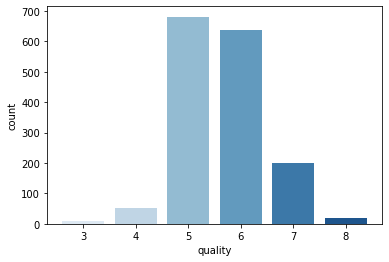

In [11]:
# Count the different quality values
sns.countplot(df['quality'],
              palette='Blues',
              label="Quality Count", )
plt.plot()
plt.savefig('data/charts/bc_diag_countplot.png')

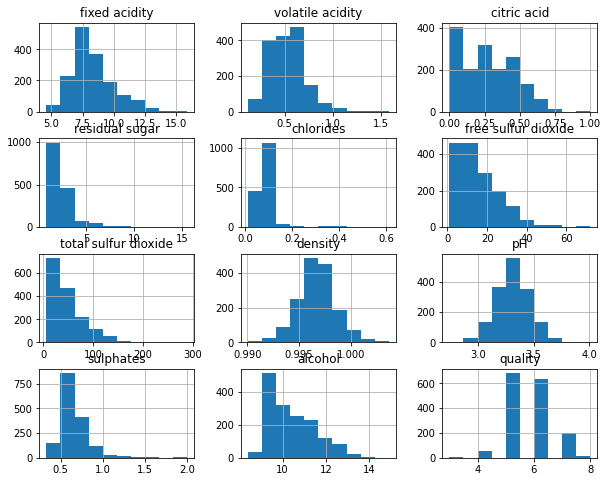

In [12]:
# Create mini-histograms for each attribute
df.hist(bins=10,
        figsize=(10, 8))
plt.show()

# Build density plots
# df.plot(kind='density',
#         subplots=True,
#         sharex=False,
#         layout=(3,4))
# plt.show()

In [13]:
# Try a scatterplot matrix from https://medium.com/analytics-vidhya/step-by-step-guide-for-predicting-wine-quality-using-scikit-learn-de5869f8f91a

In [14]:
# Build a heatmap to find the attributes that correlate the most
# f,ax = plt.subplots(figsize=(12, 14))
# conf_matrix = np.triu(correlations)
# sns.heatmap(df.corr(),
#             annot=True,
#             cbar=0,
#             linewidths=.3,
#             fmt='.1f',
#             cmap='Blues',
#             ax=ax,
#             mask=conf_matrix)
# plt.plot()

In [15]:
# Find the amount of correlation between each column and the quality
corrs = df.corr()
corr_quality = corrs['quality']
print('Amount of correlation (Pearsons r) for each column:')
print(corr_quality.sort_values(ascending=False))

Amount of correlation (Pearsons r) for each column:
quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


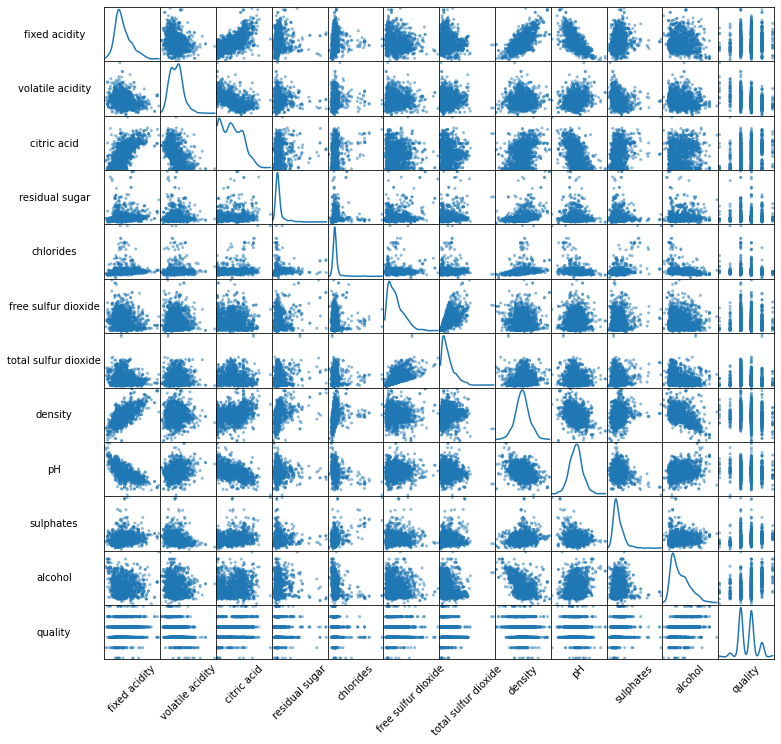

In [16]:
# Create a scatterplot matrix with a Kernel Density estimation on the diagonal
scatter_matrix = pd.plotting.scatter_matrix(df, diagonal='kde', cmap='Blues', figsize=(12, 12))

#May need to offset label when rotating to prevent overlap of figure
[scat.get_yaxis().set_label_coords(-0.9, 0.4) for scat in scatter_matrix.reshape(-1)]

# Rotate all of the column names
[scat.xaxis.label.set_rotation(45) for scat in scatter_matrix.reshape(-1)]
[scat.yaxis.label.set_rotation(0) for scat in scatter_matrix.reshape(-1)]

# Remove all of the markings and numbers along the axes
[scat.set_xticks(()) for scat in scatter_matrix.reshape(-1)]
[scat.set_yticks(()) for scat in scatter_matrix.reshape(-1)]

plt.show()

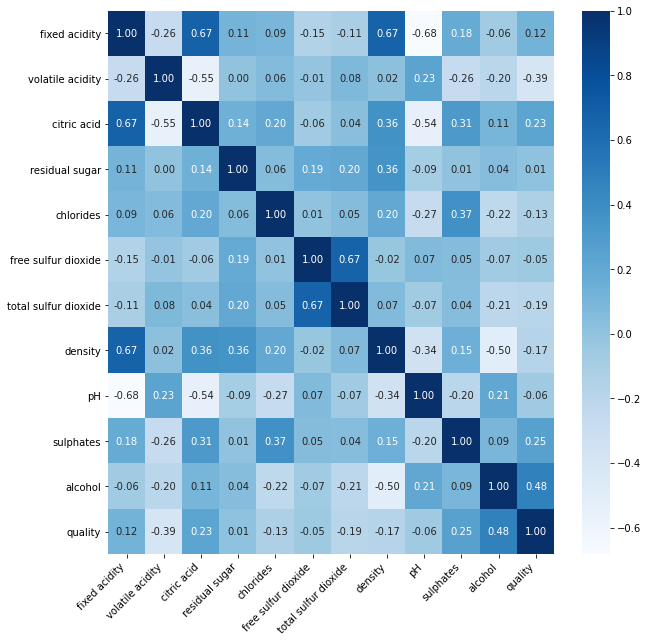

In [17]:
col_names = ['fixed acidity',
             'volatile acidity',
             'citric acid',
             'residual sugar',
             'chlorides',
             'free sulfur dioxide',
             'total sulfur dioxide',
             'density',
             'pH',
             'sulphates',
             'alcohol',
             'quality']
fig, ax = plt.subplots(figsize=(10, 10))

# Create color map
colormap = sns.diverging_palette(220,
                                 10,
                                 as_cmap=True)

# Create Heat Map, including annotations
# Put the floating point numbers in the map
sns.heatmap(corrs,
            cmap='Blues',
            fmt=".2f",
            annot=True)

ax.set_xticklabels(
    col_names,
    horizontalalignment='right',
    rotation=45)

ax.set_yticklabels(col_names)
plt.show()

In [18]:
# for (col_name, _) in df.iteritems():
#     print(f"{col_name}: {df[col_name].corr(df['quality'], method='pearson'):.2f}")

[]

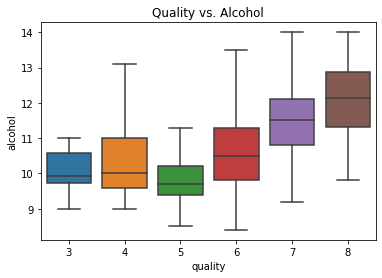

In [19]:
###############################
# Build boxplots for the most correlated against the different quality levels (3)

## Alcohol
plot = sns.boxplot(x='quality',
                   y='alcohol',
                   data=df,
                   showfliers=False)
plot.set_title('Quality vs. Alcohol')
plt.plot()

[]

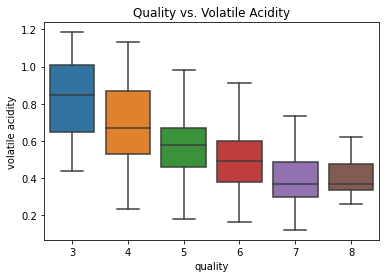

In [20]:
## Volatile acidity
plot = sns.boxplot(x='quality',
                   y='volatile acidity',
                   data=df,
                   showfliers=False)
plot.set_title('Quality vs. Volatile Acidity')
plt.plot()

[]

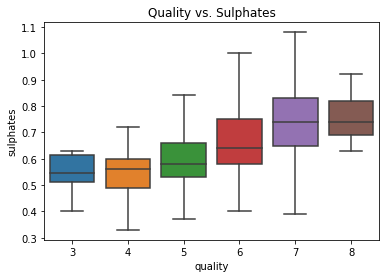

In [21]:
## Sulphates
plot = sns.boxplot(x='quality',
                   y='sulphates',
                   data=df,
                   showfliers=False)
plot.set_title('Quality vs. Sulphates')
plt.plot()

[]

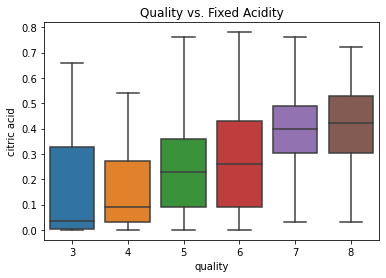

In [22]:
## Citric Acid
plot = sns.boxplot(x='quality',
                   y='citric acid',
                   data=df,
                   showfliers=False)
plot.set_title('Quality vs. Fixed Acidity')
plt.plot()

[]

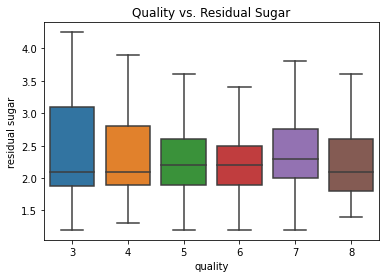

In [23]:
## Residual Sugar
plot = sns.boxplot(x='quality',
                   y='residual sugar',
                   data=df,
                   showfliers=False)
plot.set_title('Quality vs. Residual Sugar')
plt.plot()

In [24]:
## Split the data up.
y = df['quality']
X = df.drop('quality', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=14)
print(df.shape)

(1599, 12)


In [25]:
# Scale the features (attributes)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [26]:
# Logistical Regression
lr = LogisticRegression(random_state = 0, max_iter=200)
lr.fit(x_train, y_train)

print(f'logistic regression training accuracy: {lr.score(x_train, y_train)}')

NameError: name 'LogisticRegression' is not defined

In [ ]:
# using decisiontreeclassifier
tree = dtc(criterion = 'gini', random_state = 0)
tree.fit(x_train, y_train)
print('[3]decision tree classifier training accuracy:', tree.score(x_train, y_train))

In [ ]:
tree_predictions = tree.predict(x_test)
tree_accuracy = accuracy_score(y_test, tree_predictions)
print(f'tree accuracy = {tree_accuracy}')

In [27]:
# # print(cross_val_score(decisiontreeclassifier(criterion = 'gini', random_state = 0), x_train, y_train, cv=5))
# def gridsearch(estimator, param_grid, cv):
#     # criterion = ['gini', 'entropy']
#     # hah = dict(criterion=criterion)
#     clf = gridsearchcv(estimator=estimator,
#                        param_grid=param_grid,
#                        n_jobs=-1,
#                        cv=cv,
#                        return_train_score=True,
#                        scoring=make_scorer(mean_squared_error))
#
#     clf.fit(X_train, y_train)
#
#     ### Output the results
#
#     print(f'Best parameters: {clf.best_params_}')
#     print(f'Best score: {clf.best_score_}')
#     best_estimate = clf.best_estimator_
#     print(best_estimate)
#
#     ## Now we have found the best parameters, use them...
#     best_estimate.fit(X_train,y_train)
#
#     predictor = best_estimate.predict(X_train)
#     mse = mean_squared_error(predictor, y_train)
#     r2 = r2_score(predictor, y_train)
#     print(f'Training Mean Square Error: {mse:.2f}')
#     print(f'Training R2: {r2:.2f}')
#
#     y_predictor = best_estimate.predict(X_test)
#     mse = mean_squared_error(y_test, y_predictor)
#     r2 = r2_score(y_test, y_predictor)
#     print(f'Testing Mean Square Error: {mse:.2f}')
#     print(f'Testing R2: {r2:.2f}')
#     print('blah')
#
#     return best_estimate, y_predictor
#
#

In [28]:
# def cm_and_class_rep(X_test, y_test, y_predictor, best_estimate):
#     confusion_matrix(y_test, y_predictor)
#     plot_confusion_matrix(best_estimate,
#                           X_test,
#                           y_test,
#                           cmap=plt.cm.Blues,
#                           normalize='true' )
#
#     print(classification_report(y_test, y_predictor))
#
#
#

In [29]:

# from sklearn import tree as tr
# # Output diagram of the decision tree.
# fig = plt.figure(figsize=(300, 240))
# _ = tr.plot_tree(dtc_best_estimate,
#                    filled=True)
# fig.savefig("decision_tree.png")
#

In [30]:
# def draw_learning_curve(estimator, X_train, y_train, cv, train_max):
#
#     # Do the curbe
#     sizes, \
#     training_scores, \
#     testing_scores, \
#     fit_times, \
#     score_times = learning_curve(estimator,
#                                  X_train,
#                                  y_train,
#                                  cv=cv,
#                                  scoring='recall',
#                                  return_times=True,
#                                  train_sizes=np.arange(1, train_max, 10))
#
#     # Standard Deviation and Mean of training scores
#     Standard_Deviation_training = np.std(training_scores, axis=1)
#     mean_training = np.mean(training_scores, axis=1)
#     print(f'mean_training = {mean_training}')
#     print(f'\nTraining SD = {Standard_Deviation_training}')
#
#     # Standard Deviation and Mean of testing scores
#     Standard_Deviation_testing = np.std(testing_scores, axis=1)
#     mean_testing = np.mean(testing_scores, axis=1)
#     print(f'mean_testing = {mean_testing}')
#     print(f'\nTesting SD = {Standard_Deviation_testing}')
#
#     # Do the plot
#     plt.plot(sizes, mean_training, '--', label='Training Score', color='r')
#     plt.plot(sizes, mean_testing, color='b', label='Cross Validation Score')
#     plt.title('Decision Tree Learning Curve')
#     plt.xlabel('Training Set Size'), plt.ylabel('Accuracy'), plt.legend(loc="best")
#     plt.tight_layout()
#     plt.savefig('data/dt_learning_curve.png')
#     plt.show()


In [31]:
# print(cross_val_score(decisiontreeclassifier(criterion = 'gini', random_state = 0), x_train, y_train, cv=5))
def gridsearch(estimator, param_grid, cv, scoring_metric):
    scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'weighted')
    clf = gridsearchcv(estimator=estimator,
                       param_grid=param_grid,
                       n_jobs=-1,
                       cv=cv,
                       return_train_score=True,
                       scoring=scorer,
                       verbose=3)
    clf.fit(X_train, y_train)

    ### Output the results
    print(f'Best parameters: {clf.best_params_}')
    print(f'Best score: {clf.best_score_}')
    best_estimate = clf.best_estimator_
    print(best_estimate)

    ## Now we have found the best parameters, use them...
    best_estimate.fit(X_train,y_train)

    predictor = best_estimate.predict(X_train)
    mse = mean_squared_error(predictor, y_train)
    r2 = r2_score(predictor, y_train)
    print(f'Training Mean Square Error: {mse:.2f}')
    print(f'Training R2: {r2:.2f}')

    y_predictor = best_estimate.predict(X_test)
    mse = mean_squared_error(y_test, y_predictor)
    r2 = r2_score(y_test, y_predictor)
    print(f'Testing Mean Square Error: {mse:.2f}')
    print(f'Testing R2: {r2:.2f}')
    print('blah')

    return best_estimate, y_predictor


In [32]:
def cm_and_class_rep(X_test, y_test, y_predictor, best_estimate):
    confusion_matrix(y_test, y_predictor)
    cm = plot_confusion_matrix(best_estimate,
                               X_test,
                               y_test,
                               cmap=plt.cm.Blues,
                               normalize='true' )
    plt.show(cm)
    plt.show()
    print(classification_report(y_test, y_predictor))

In [33]:
def draw_learning_curve(estimator_1,
                        estimator_1_name,
                        estimator_2,
                        estimator_2_name,
                        estimator_3,
                        estimator_3_name,
                        X_train,
                        y_train,
                        cv,
                        train_max,
                        title):

    # Set plot size
    plt.figure(figsize=(7,5))

    ###################################
    # Do the 1st curve
    sizes, \
    training_scores, \
    testing_scores, \
    fit_times, \
    score_times = learning_curve(estimator_1,
                                 X_train,
                                 y_train,
                                 cv=cv,
                                 scoring='accuracy',
                                 return_times=True,
                                 train_sizes=np.arange(1, train_max, 10))

    # Mean of training scores
    mean_training = np.mean(training_scores, axis=1)

    # Mean of testing scores
    mean_testing = np.mean(testing_scores, axis=1)

    # Do the best lines
    plt.plot(sizes,
             mean_training,
             '--',
             label='Training Score - ' + estimator_1_name,
             color='blue')
    plt.plot(sizes,
             mean_testing,
             label='Cross Validation Score - ' + estimator_1_name,
             color='cornflowerblue')


    ###################################
    # Do the 2nd curve
    sizes, \
    training_scores, \
    testing_scores, \
    fit_times, \
    score_times = learning_curve(estimator_2,
                                 X_train,
                                 y_train,
                                 cv=cv,
                                 scoring='accuracy',
                                 return_times=True,
                                 train_sizes=np.arange(1, train_max, 10))

    # Mean of training scores
    mean_training = np.mean(training_scores, axis=1)

    # Mean of testing scores
    mean_testing = np.mean(testing_scores, axis=1)

    # Do the best lines
    plt.plot(sizes,
             mean_training,
             '--',
             label='Training Score - ' + estimator_2_name,
             color='green')
    plt.plot(sizes,
             mean_testing,
             label='Cross Validation Score - ' + estimator_2_name,
             color='springgreen')

    ###################################
    # Do the 3rd curve
    sizes, \
    training_scores, \
    testing_scores, \
    fit_times, \
    score_times = learning_curve(estimator_3,
                                 X_train,
                                 y_train,
                                 cv=cv,
                                 scoring='accuracy',
                                 return_times=True,
                                 train_sizes=np.arange(1, train_max, 10))

    # Mean of training scores
    mean_training = np.mean(training_scores, axis=1)

    # Mean of testing scores
    mean_testing = np.mean(testing_scores, axis=1)

    # Do the best lines
    plt.plot(sizes,
             mean_training,
             '--',
             label='Training Score - ' + estimator_3_name,
             color='red')
    plt.plot(sizes,
             mean_testing,
             label='Cross Validation Score - ' + estimator_3_name,
             color='lightcoral')

    # Do the final plots
    plt.title(title)
    plt.xlabel('Training Set Size'), plt.ylabel('Accuracy'), plt.legend(loc="best")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.savefig('data/charts/wine_learning_curve.png')
    plt.show()

In [39]:
# Draw Validation Curve
def draw_validation_curve(estimator, X_train, y_train, cv, param_name, param_range, title, xlabel):

    train_scores, test_scores = validation_curve(estimator,
                                                 X_train,
                                                 y_train,
                                                 param_name=param_name,
                                                 param_range=param_range,
                                                 cv=cv,
                                                 scoring='accuracy',
                                                 n_jobs=-1)

    # Mean from the scores for the training set
    train_mean = np.mean(train_scores, axis=1)

    # Mean from the scores for the test set
    test_mean = np.mean(test_scores, axis=1)

    # Create plot for training
    plt.plot(param_range,
             train_mean,
             label="Training score",
             color="blue")

    # Create plot for testing
    plt.plot(param_range,
             test_mean,
             label="Cross-validation score",
             color="red")

    # Build plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig('data/charts/wine_validation_curve.png')
    plt.show()

dt_max_depth = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Fitting 8 folds for each of 120 candidates, totalling 960 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 27}
Best score: 0.6117764304306907
DecisionTreeClassifier(class_weight='balanced', max_depth=27)
Training Mean Square Error: 0.00
Training R2: 1.00
Testing Mean Square Error: 0.64
Testing R2: 0.02
blah
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.18      0.19      0.18        16
           5       0.68      0.73      0.70       204
           6       0.63      0.59      0.61       192
           7       0.47      0.47      0.47        60
           8       0.33      0.20      0.25         5

    accuracy                           0.61       480
   macro avg       0.38      0.36      0.37       480
weighted avg       0.61      0.61      0.

/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 740 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:    2.4s finished


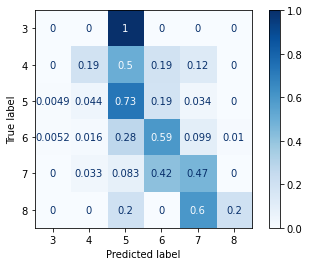

In [40]:
# Do Decision Tree stuff...

# Do a grid search for the Decision Tree
dt_criterion = ['gini', 'entropy']
dt_max_depth = [count for count in range(0, 30)]
dt_class_weight = [None, 'balanced']
print(f'dt_max_depth = {dt_max_depth}')
param_grid = dict(criterion=dt_criterion,
                  max_depth=dt_max_depth,
                  class_weight=dt_class_weight)

best_estimate, y_predictor = gridsearch(estimator=dtc(),
                                        param_grid=param_grid,
                                        cv=8,
                                        scoring_metric='recall')

cm_and_class_rep(X_test, y_test, y_predictor, best_estimate)

/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"
/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"
/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"


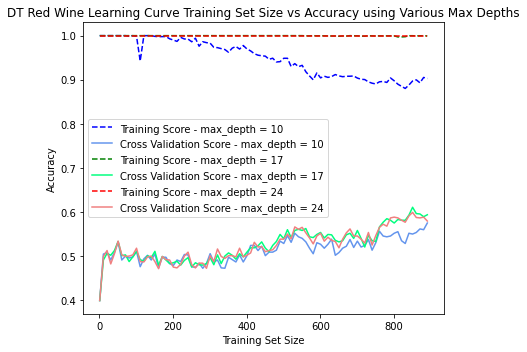

In [41]:
# Decision Tree learning curve

## TODO: Grab these values from best_estimate above
tuned_criterion = 'entropy'
tuned_max_depth=17
tuned_class_weight='balanced'

# Best depth
draw_learning_curve(dtc(criterion=tuned_criterion,
                        max_depth=10,
                        class_weight=tuned_class_weight),
                    'max_depth = 10',
                    dtc(criterion=tuned_criterion,
                        max_depth=17,
                        class_weight=tuned_class_weight),
                    'max_depth = 17',
                    dtc(criterion=tuned_criterion,
                        max_depth=24,
                        class_weight=tuned_class_weight),
                    'max_depth = 24',
                    X_train,
                    y_train,
                    cv=8,
                    train_max=900,
                    title = 'DT Red Wine Learning Curve Training Set Size vs Accuracy using Various Max Depths')

/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"


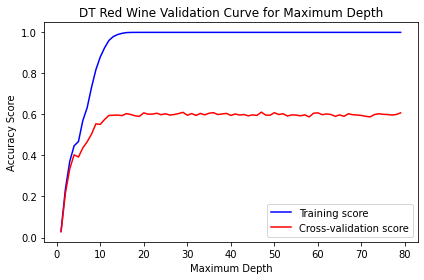

In [42]:
# Draw Decision Tree Validation Curve
draw_validation_curve(dtc(criterion=tuned_criterion,
                          class_weight=tuned_class_weight),
                      X_train,
                      y_train,
                      cv=8,
                      param_name='max_depth',
                      param_range=np.arange(0,80),
                      title='DT Red Wine Validation Curve for Maximum Depth',
                      xlabel='Maximum Depth')

Fitting 8 folds for each of 216 candidates, totalling 1728 fits
Best parameters: {'algorithm': 'kd_tree', 'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
Best score: 0.664256670632593
KNeighborsClassifier(algorithm='kd_tree', metric='manhattan', n_neighbors=13,
                     weights='distance')
Training Mean Square Error: 0.00
Training R2: 1.00
Testing Mean Square Error: 0.40
Testing R2: 0.38
blah
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        16
           5       0.72      0.76      0.74       204
           6       0.64      0.69      0.67       192
           7       0.74      0.65      0.69        60
           8       1.00      0.20      0.33         5

    accuracy                           0.69       480
   macro avg       0.52      0.38      0.40       480
weighted avg       0.66      0.69      0.67       480



/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1713 out of 1728 | elapsed:   15.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:   15.7s finished
/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


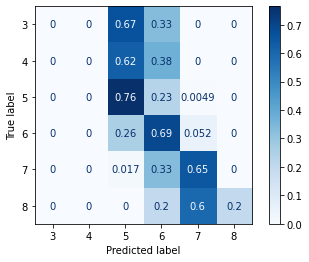

In [50]:
# Do KNN stuff
# Set the parameters by cross-validation
MAX_NEIGHBORS=19
n_neighbors=[layers for layers in range(1, MAX_NEIGHBORS)]
metric=['manhattan', 'euclidean', 'chebyshev']
weights=['uniform', 'distance']
algorithm=['kd_tree', 'ball_tree']
param_grid = dict(n_neighbors=n_neighbors,
                  metric=metric,
                  weights=weights,
                  algorithm=algorithm)
best_estimate, y_predictor = gridsearch(estimator=knn(),
                                        param_grid=param_grid,
                                        cv=8,
                                        scoring_metric='precision')

cm_and_class_rep(X_test, y_test, y_predictor, best_estimate)


In [52]:
# KNN learning curve
tuned_n_neighbors = 13
tuned_metric = 'manhattan'
tuned_weights = 'distance'
tuned_algorithm = 'kd_tree'

draw_learning_curve(knn(n_neighbors=3,
                        metric=tuned_metric,
                        weights=tuned_weights,
                        algorithm=tuned_algorithm),
                    'Nearest Neighbors = 2',
                    knn(n_neighbors=4,
                        metric=tuned_metric,
                        weights=tuned_weights,
                        algorithm=tuned_algorithm),
                    'Nearest Neighbors = 3',
                    knn(n_neighbors=5,
                        metric=tuned_metric,
                        weights=tuned_weights,
                        algorithm=tuned_algorithm),
                    'Nearest Neighbors = 4',
                    X_train,
                    y_train,
                    cv=8,
                    train_max=500,
                    title = 'KNN Red Wine Learning Curve Training Set Size vs Nearest Neighbors')

/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 3

<Figure size 504x360 with 0 Axes>

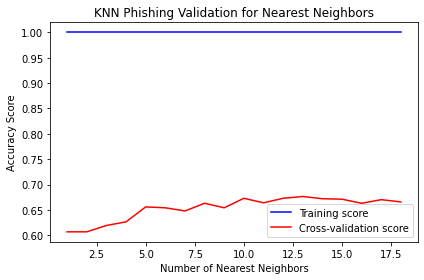

In [55]:
tuned_n_neighbors = 13
tuned_metric = 'manhattan'
tuned_weights = 'distance'
tuned_algorithm = 'kd_tree'

# Draw KNN Validation Curve
draw_validation_curve(knn(n_neighbors=tuned_n_neighbors,
                          metric=tuned_metric,
                          weights=tuned_weights,
                          algorithm=tuned_algorithm),
                      X_train,
                      y_train,
                      cv=7,
                      param_name='n_neighbors',
                      param_range=np.arange(0, MAX_NEIGHBORS),
                      title='KNN Red Wine Validation for Nearest Neighbors',
                      xlabel='Number of Nearest Neighbors')

Fitting 10 folds for each of 21 candidates, totalling 210 fits
Best parameters: {'learning_rate': 0.16, 'n_estimators': 30}
Best score: 0.5304496054182952
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='entropy',
                                                         max_depth=2),
                   learning_rate=0.16, n_estimators=30)
Training Mean Square Error: 0.73
Training R2: 0.12
Testing Mean Square Error: 0.72
Testing R2: -0.11
blah
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.13      0.38      0.19        16
           5       0.61      0.72      0.66       204
           6       0.56      0.30      0.39       192
           7       0.38      0.57      0.45        60
           8       0.00      0.00      0.00         5

    accuracy                           0.51       480
   macro avg      

/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.5s finished
/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


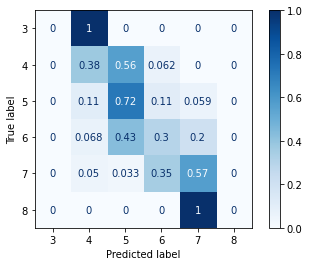

In [60]:
# Do Boosting stuff
# Set the parameters by cross-validation
ada_learning_rate = [(2**x)/100 for x in range(7)]
# ada_n_estimators = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ada_n_estimators = [20, 30, 40]
# N.B. These hyper-parameters are from previous decision tree tuning.
ada_dt = dtc(criterion=tuned_criterion,
             max_depth=tuned_max_depth,
             class_weight=tuned_class_weight)
param_grid = dict(learning_rate=ada_learning_rate,
                  n_estimators=ada_n_estimators)
best_estimate, y_predictor = gridsearch(estimator=ada(ada_dt),
                                        param_grid=param_grid,
                                        cv=10,
                                        scoring_metric='recall')

cm_and_class_rep(X_test, y_test, y_predictor, best_estimate)

/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"
/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"
/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"


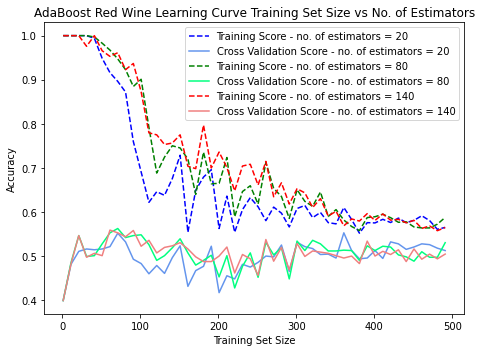

In [59]:
# Boosting learning curve

## Grab these values from best_estimate above
tuned_learning_rate = 0.16
tuned_n_estimators = 80

draw_learning_curve(ada(ada_dt,
                        learning_rate=tuned_learning_rate,
                        n_estimators=20),
                    'no. of estimators = 20',
                    ada(ada_dt,
                        learning_rate=tuned_learning_rate,
                        n_estimators=80),
                    'no. of estimators = 80',
                    ada(ada_dt,
                        learning_rate=tuned_learning_rate,
                        n_estimators=140),
                    'no. of estimators = 140',
                    X_train,
                    y_train,
                    cv=8,
                    train_max=500,
                    title = 'AdaBoost Red Wine Learning Curve Training Set Size vs No. of Estimators')

/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"


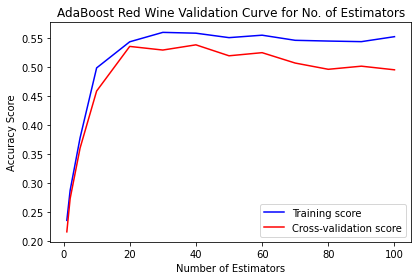

In [58]:
# Draw Boosting Validation Curve
draw_validation_curve(ada(ada_dt,
                          learning_rate=tuned_learning_rate,
                          n_estimators=tuned_n_estimators),
                      X_train,
                      y_train,
                      cv=8,
                      param_name='n_estimators',
                      param_range=ada_n_estimators,
                      title='AdaBoost Red Wine Validation Curve for No. of Estimators',
                      xlabel='Number of Estimators')

Fitting 8 folds for each of 40 candidates, totalling 320 fits
Best parameters: {'C': 2.001, 'gamma': 0.1, 'kernel': 'rbf', 'tol': 0.050000010000000004}
Best score: 0.6065698365309541
SVC(C=2.001, gamma=0.1, tol=0.050000010000000004)
Training Mean Square Error: 0.39
Training R2: 0.03
Testing Mean Square Error: 0.47
Testing R2: 0.28
blah
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        16
           5       0.66      0.78      0.71       204
           6       0.58      0.59      0.58       192
           7       0.66      0.42      0.51        60
           8       0.00      0.00      0.00         5

    accuracy                           0.62       480
   macro avg       0.31      0.30      0.30       480
weighted avg       0.59      0.62      0.60       480



/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 136.3min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 148.6min finished
/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


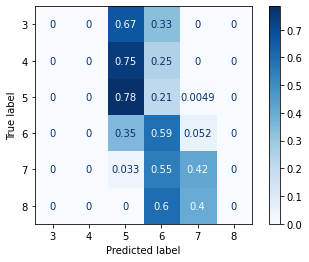

In [61]:
# Do SVM stuff
# Set the parameters by cross-validation
svc_C = np.arange(0.001, 2.5, 0.5)
svc_tol = np.arange(1e-8, 1e-1, 0.05)
svc_kernel = ['linear', 'poly', 'rbf', 'sigmoid']
# svc_gamma = [1, 0.1, 0.01, 0.001, 0.0001]
svc_gamma = [0.1]
param_grid = dict(C=svc_C,
                  tol=svc_tol,
                  kernel=svc_kernel,
                  gamma = svc_gamma)
best_estimate, y_predictor = gridsearch(estimator=svc(),
                                        param_grid=param_grid,
                                        cv=8,
                                        scoring_metric='precision')

cm_and_class_rep(X_test, y_test, y_predictor, best_estimate)

/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"
/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/svm/_base.py", line 164, in fit
    y = self._validate_targets(y)
  File "/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/svm/_base.py", line 549, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be gre

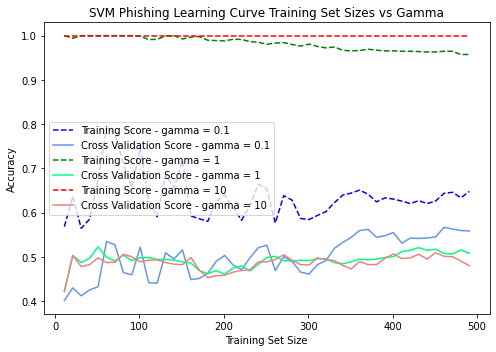

In [48]:
tuned_C = 1.501
tuned_tol = 1 ** -8
tuned_kernel = 'rbf'
tuned_gamma = 1

# SVM learning curve
draw_learning_curve(svc(C=tuned_C,
                        tol=tuned_tol,
                        kernel=tuned_kernel,
                        gamma=0.1),
                        'gamma = 0.1',
                    svc(C=tuned_C,
                        tol=tuned_tol,
                        kernel=tuned_kernel,
                        gamma=1),
                     'gamma = 1',
                    svc(C=tuned_C,
                        tol=tuned_tol,
                        kernel=tuned_kernel,
                        gamma=10),
                    'gamma = 10',
                    X_train,
                    y_train,
                    cv=8,
                    train_max=500,
                    title = 'SVM Red Wine Learning Curve Training Set Sizes vs Gamma')

/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"


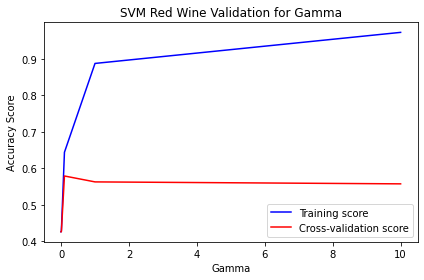

In [64]:
# Draw SVM Validation Curve
draw_validation_curve(svc(C=tuned_C,
                          tol=tuned_tol,
                          kernel=tuned_kernel,
                          gamma=1),
                      X_train,
                      y_train,
                      cv=8,
                      param_name='gamma',
                      param_range=[10, 1, 0.1, 0.01, 0.001, 0.0001],
                      title='SVM Red Wine Validation for Gamma',
                      xlabel='Gamma')

In [ ]:
# Do MLP stuff...
MAX_LAYER_SIZE = 20
hidden_layer_sizes = [layers for layers in range(1, MAX_LAYER_SIZE)]
activation = ['tanh', 'relu']
max_iter = [500, 1000, 1500, 2000]
alpha = 10.0 ** -np.arange(1,7)
learning_rate = ['constant', 'adaptive']
param_grid = dict(hidden_layer_sizes=hidden_layer_sizes,
                  activation=activation,
                  max_iter=max_iter,
                  alpha=alpha,
                  learning_rate=learning_rate)

best_estimate, y_predictor = gridsearch(estimator=mlp(),
                                        param_grid=param_grid,
                                        cv=8,
                                        scoring_metric='precision')

cm_and_class_rep(X_test, y_test, y_predictor, best_estimate)


# MLP learning curve
tuned_hidden_layer_sizes = 19
tuned_activation = 'tanh'
tuned_max_iter = 1000
tuned_alpha = 1e-06
tuned_learning_rate = 'constant'

draw_learning_curve(mlp(hidden_layer_sizes=4,
                        activation=tuned_activation,
                        max_iter=tuned_max_iter,
                        alpha=tuned_alpha,
                        learning_rate=tuned_learning_rate),
                    'hidden_layer_size = 14',
                    mlp(hidden_layer_sizes=tuned_hidden_layer_sizes,
                        activation=tuned_activation,
                        max_iter=tuned_max_iter,
                        alpha=tuned_alpha,
                        learning_rate=tuned_learning_rate),
                    'hidden_layer_size = 19',
                    mlp(hidden_layer_sizes=34,
                        activation=tuned_activation,
                        max_iter=tuned_max_iter,
                        alpha=tuned_alpha,
                        learning_rate=tuned_learning_rate),
                    'hidden_layer_size = 24',
                    X_train,
                    y_train,
                    cv=8,
                    train_max=500,
                    title = 'MLP Phishing Learning Curve Training Set Size vs. hidden layer size')


In [ ]:
# Draw MLP Validation Curve
draw_validation_curve(mlp(hidden_layer_sizes=tuned_hidden_layer_sizes,
                          activation=tuned_activation,
                          max_iter=tuned_max_iter,
                          alpha=tuned_alpha,
                          learning_rate=tuned_learning_rate),
                      X_train,
                      y_train,
                      cv=8,
                      param_name='hidden_layer_sizes',
                      param_range=np.arange(0, MAX_LAYER_SIZE),
                      title='MLP Phishing Validation Curve for Hidden Layer Sizes',
                      xlabel='Hidden Layer Sizes')









































































/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"


Best parameters: {'criterion': 'entropy', 'max_depth': 36}
Best score: 0.708832219938335
DecisionTreeClassifier(criterion='entropy', max_depth=36)
Training Mean Square Error: 0.00
Training R2: 1.00
Testing Mean Square Error: 0.67
Testing R2: -0.04
blah
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.29      0.12      0.17        16
           5       0.62      0.65      0.63       204
           6       0.54      0.54      0.54       192
           7       0.48      0.48      0.48        60
           8       0.20      0.20      0.20         5

    accuracy                           0.56       480
   macro avg       0.35      0.33      0.34       480
weighted avg       0.55      0.56      0.55       480



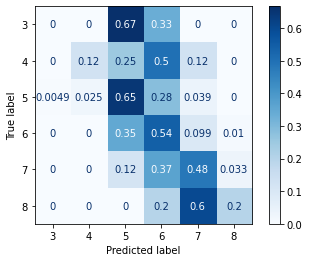

In [10]:
# Do Decision Tree stuff...

# Do a grid search for the Decision Tree
criterion = ['gini', 'entropy']
max_depth = [count for count in range(1, 60)]

param_grid = dict(criterion=criterion,
                  max_depth=max_depth)

best_estimate, y_predictor = gridsearch(estimator=dtc(), param_grid=param_grid, cv=8)

cm_and_class_rep(X_test, y_test, y_predictor, best_estimate)

In [ ]:
#Decision Tree learning curve

draw_learning_curve(dtc(criterion='entropy',
                        max_depth=2),
                        X_train,
                        y_train,
                        cv=8,
                        train_max=900)


In [143]:

# Using the Multi-Layer Perceptron
# Finds RND_COUNT_NUM random number of 1 layers count, RND_COUNT_NUM of 2, all the way to MAX_LAYERS
# MAX_LAYERSMAX_LAYERS = 5
# RND_COUNT_NUM = 100
#
# max_accuracy = 0
# best_layers = ()
# past_layers = []
#
# print('hey')
# for count in range(RND_COUNT_NUM):
#     layers = ()
#     for param_count in range (1, 5):
#         layers = tuple(random.randint(1, MAX_LAYER_SIZE) for _ in range(param_count))
#
#         if layers not in past_layers:
#             print(layers)
#             past_layers.append(layers)
#
#             if mlp_accuracy > max_accuracy:
#                 max_accuracy = mlp_accuracy
#                 best_layers = layers
mlp = MLPClassifier(max_iter=999, hidden_layer_sizes=layers)
mlp.fit(X_train, y_train)

## MLP matrix and classification report
mlp_predictions = mlp.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)

print(f'max_accuracy = {max_accuracy}')
print(f'best_layers = {best_layers}')

mlp_cm = confusion_matrix(y_test, mlp_predictions)

# TN = cm[0][0]
# TP = cm[1][1]
# FN = cm[1][0]
# FP = cm[0][1]

# print(cm)
# print('Model[{}] Testing Accuracy = "{}"'.format(tree, (TP + TN) / (TP + TN + FN + FP)))
# print()# Print a new line
# plot_confusion_matrix(mlp,
#                       X_test,
#                       y_test,
#                       cmap=plt.cm.Blues,
#                       normalize='true' )
#
# print(classification_report(y_test, mlp_predictions))

ValueError: multiclass format is not supported

/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"
/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

Best parameters: {'alpha': 1e-05, 'hidden_layer_sizes': array([ 5,  6,  7,  8,  9, 10, 11, 12]), 'max_iter': 500}
Best score: 0.5755202980472764
MLPClassifier(alpha=1e-05,
              hidden_layer_sizes=array([ 5,  6,  7,  8,  9, 10, 11, 12]),
              max_iter=500)
Training Mean Square Error: 0.43
Training R2: 0.00
Testing Mean Square Error: 0.54
Testing R2: 0.17
blah
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        16
           5       0.60      0.69      0.64       204
           6       0.50      0.52      0.51       192
           7       0.55      0.37      0.44        60
           8       0.00      0.00      0.00         5

    accuracy                           0.55       480
   macro avg       0.27      0.26      0.26       480
weighted avg       0.52      0.55      0.53       480



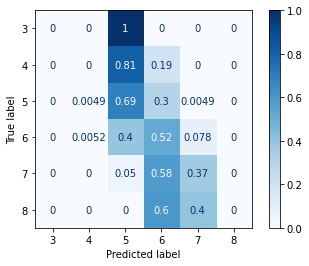

In [11]:
# Do MLP stuff...
MAX_LAYER_SIZE = 30
hidden_layer_sizes = [layers for layers in range(1, MAX_LAYER_SIZE)]
hidden_layer_sizes = np.arange(5,13)
max_iter = [500, 1000, 1500, 2000, 2500]
alpha = 10.0 ** -np.arange(1,7)
param_grid = dict(hidden_layer_sizes=[hidden_layer_sizes],
                  max_iter=max_iter,
                  alpha=alpha)

best_estimate, y_predictor = gridsearch(estimator=mlp(), param_grid=param_grid, cv=8)

cm_and_class_rep(X_test, y_test, y_predictor, best_estimate)

In [29]:
# MLP learning curve

draw_learning_curve(mlp(alpha=1e-06,
                        hidden_layer_sizes=[5],
                        max_iter=200),
                        X_train,
                        y_train,
                        cv=2,
                        train_max=400)

# Best parameters: {'alpha': 1e-06, 'hidden_layer_sizes': array([ 5,  6,  7,  8,  9, 10, 11, 12]), 'max_iter': 1500}
# Best score: 0.5808389003083247
# MLPClassifier(alpha=1e-06,
#               hidden_layer_sizes=array([ 5,  6,  7,  8,  9, 10, 11, 12]),
#               max_iter=1500)

/home/poblivsig/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [144]:

best_estimate, y_predictor = gridsearch(estimator=mlp(), param_grid=param_grid, cv=8)

/home/poblivsig/Dropbox/horses2/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"


Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': array([ 5,  6,  7,  8,  9, 10, 11, 12]), 'max_iter': 1500}
Best score: 0.58707605344296
MLPClassifier(hidden_layer_sizes=array([ 5,  6,  7,  8,  9, 10, 11, 12]),
              max_iter=1500)
Training Mean Square Error: 0.00
Training R2: 1.00
Testing Mean Square Error: 0.66
Testing R2: -0.03
blah



              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.33      0.12      0.18        16
           5       0.60      0.65      0.63       204
           6       0.55      0.54      0.54       192
           7       0.48      0.48      0.48        60
           8       0.17      0.20      0.18         5

    accuracy                           0.56       480
   macro avg       0.36      0.33      0.34       480
weighted avg       0.55      0.56      0.55       480



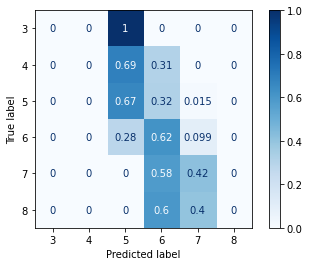

In [34]:
# Do KNN stuff
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

hidden_layer_sizes = [layers for layers in range(1, MAX_LAYER_SIZE)]
hidden_layer_sizes = np.arange(5,13)
max_iter = [500, 1000, 1500, 2000, 2500]
alpha = 10.0 ** -np.arange(1,7)
param_grid = dict(hidden_layer_sizes=[hidden_layer_sizes],
                  max_iter=max_iter,
                  alpha=alpha)
best_estimate, y_predictor = gridsearch(estimator=mlp(), param_grid=param_grid, cv=8)

cm_and_class_rep(X_test, y_test, y_predictor, best_estimate)












/Users/paullivesey/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(("The least populated class in y has only %d"
/Users/paullivesey/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paullivesey/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paullivesey/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings

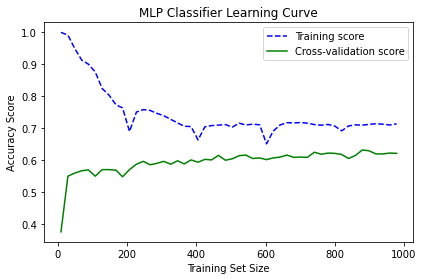

In [35]:
# Learning curve for the neural network
sizes, training_scores, testing_scores = learning_curve(mlp(),
                                                        X_train,
                                                        y_train,
                                                        cv=8,
                                                        scoring='accuracy',
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
# Mean and Standard Deviation of training scores
mean_training = np.mean(training_scores, axis=1)
Standard_Deviation_training = np.std(training_scores, axis=1)

# Mean and Standard Deviation of testing scores
mean_testing = np.mean(testing_scores, axis=1)
Standard_Deviation_testing = np.std(testing_scores, axis=1)

# dotted blue line is for training scores and green line is for cross-validation score
plt.plot(sizes, mean_training, '--', color="b",  label="Training score")
plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")

# Drawing plot
plt.title("MLP Classifier Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.savefig('dt_learning_curve.png')
plt.show()

#

In [31]:
# Use the following two to get all relevnant values:
# https://medium.com/analytics-vidhya/what-is-a-confusion-matrix-d1c0f8feda5
# https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

# For 3
# True +ve - They said it was the class and it was
print(type(cm))
TP = cm[0][0]
TN = cm[1:, 1:]
FP = cm[0][1:]
TN = cm[1:][0]
TP_sum = np.sum(cm[0][0])
TN_sum = np.sum(cm[1:][1:])
FP_sum = np.sum(cm[0][1:])
TN_sum = np.sum(cm[1:][0])
print(f'TP = \n{TP}')
print(f'TN = \n{TN}')
print(f'FP = \n{FP}')
print(f'FN = \n{FN}')

<class 'numpy.ndarray'>
TP = 
0
TN = 
[ 0  0 12  9  0  0]
FP = 
[0 4 0 0 0]
FN = 
0


In [ ]:
print(max_accuracy)